In [47]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.draw import polygon
import os
import cupy as cp
from joblib import Parallel, delayed



In [48]:
state="punjab"
image_dir = f"../data/region_performace/{state}_same_class_count/images"
label_dir = f"../data/region_performace/{state}_same_class_count/labels"

def calculate_rgb_distribution(image,bbox):
    class_id,x1,y1,x2,y2,x3,y3,x4,y4 = bbox
    img_height,img_width = image.shape[1],image.shape[0]
    coords=np.array([
        [x1*img_width,y1*img_height],
        [x2*img_width,y2*img_height],
        [x3*img_width,y3*img_height],
        [x4*img_width,y4*img_height]],dtype=np.int32

    )

    mask = np.zeros((img_height,img_width),dtype=bool)
    rr, cc = polygon(coords[:,1],coords[:,0], shape=(img_height, img_width))
    mask[rr,cc]=1
    outside_mask = ~mask
    # image_np = np.array(image)

    region_red = image[:,:,0]
    region_green = image[:,:,1]
    region_blue = image[:,:,2]
    outside_red = region_red[outside_mask]
    outside_green = region_green[outside_mask]
    outside_blue = region_blue[outside_mask]
    avg_red = outside_red.mean()
    avg_green = outside_green.mean()
    avg_blue = outside_blue.mean()
    std_red = outside_red.std()
    std_green = outside_green.std()
    std_blue = outside_blue.std()
    


    

    return avg_red,avg_green,avg_blue,std_red,std_green,std_blue


In [49]:
def process_image(image_path, label_path):
    with open(label_path, 'r') as f:
        bboxes = [list(map(float, line.strip().split())) for line in f.readlines()]
    
    with rasterio.open(image_path) as src:
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
        image = np.dstack((red, green, blue))  
    
    results = []
    for bbox in bboxes:
        result = calculate_rgb_distribution(image, bbox)
        results.append(result)
    
    return results

In [50]:
avg_reds = []
avg_greens = []
avg_blues = []
std_reds = []
std_greens = []
std_blues = []
results = []

image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')]
# print(image_paths)
label_paths = [os.path.join(label_dir, f.replace('.tif', '.txt')) for f in os.listdir(image_dir) if f.endswith('.tif')]
# print(label_paths)


results = Parallel(n_jobs=42)(delayed(process_image)(image_path, label_path) for image_path, label_path in zip(image_paths, label_paths))

for result in results:
    for avg_red, avg_green, avg_blue, std_red, std_green, std_blue in result:
            avg_reds.append(avg_red)
            avg_greens.append(avg_green)
            avg_blues.append(avg_blue)
            std_reds.append(std_red)
            std_greens.append(std_green)
            std_blues.append(std_blue)





In [51]:
# state="bihar"
mean_red = np.mean(avg_reds)
# mean_red=avg_reds.mean()

mean_green = np.mean(avg_greens)
mean_blue = np.mean(avg_blues)

mean_std_red = np.mean(std_reds)
mean_std_green = np.mean(std_greens)
mean_std_blue = np.mean(std_blues)

# Print the results
print(f"Average Red Channel: {mean_red}")
print(f"Average Green Channel: {mean_green}")
print(f"Average Blue Channel: {mean_blue}")
print(f"Standard Deviation of Red Channel: {mean_std_red}")
print(f"Standard Deviation of Green Channel: {mean_std_green}")
print(f"Standard Deviation of Blue Channel: {mean_std_blue}")

Average Red Channel: 61.439241243062085
Average Green Channel: 63.87155361700527
Average Blue Channel: 37.708818132593464
Standard Deviation of Red Channel: 42.79681061567732
Standard Deviation of Green Channel: 30.43334039858631
Standard Deviation of Blue Channel: 26.99486667472762


In [52]:
print(avg_reds)
#print max and min values
print(f"Max Red: {max(avg_reds)}")
print(f"Min Red: {min(avg_reds)}")

[56.2766408714499, 56.26829703415512, 45.963000351981854, 64.3800470125986, 59.86666585210889, 71.28255829577242, 51.575853238985104, 72.60561301656881, 62.33504308175025, 73.71488894044668, 45.42612332853649, 54.2299709352026, 55.46140013975011, 55.426018668563344, 55.47402311771462, 65.331431085259, 65.39402728332287, 65.34226501784056, 65.53807338552815, 46.82770848199885, 46.78776053756872, 106.83911916086375, 51.28533169124906, 51.30427102344775, 71.91932890170585, 68.4018550464006, 68.42252189295907, 85.22547611019074, 65.44514249828337, 54.54529196625549, 75.22076801837575, 75.20150844160288, 50.398796037629324, 49.297142438094305, 66.56401303765674, 66.56898123147522, 43.15988563888278, 62.075003298942875, 43.80945958822279, 51.24981674420423, 54.98080116433539, 54.63124265444301, 48.19579782243247, 68.90355663616259, 58.844122455662735, 49.570124655736585, 67.36923655766863, 60.018961017379915, 58.38705736318943, 41.89544146178168, 46.456737418809354, 49.52763128955793, 53.070

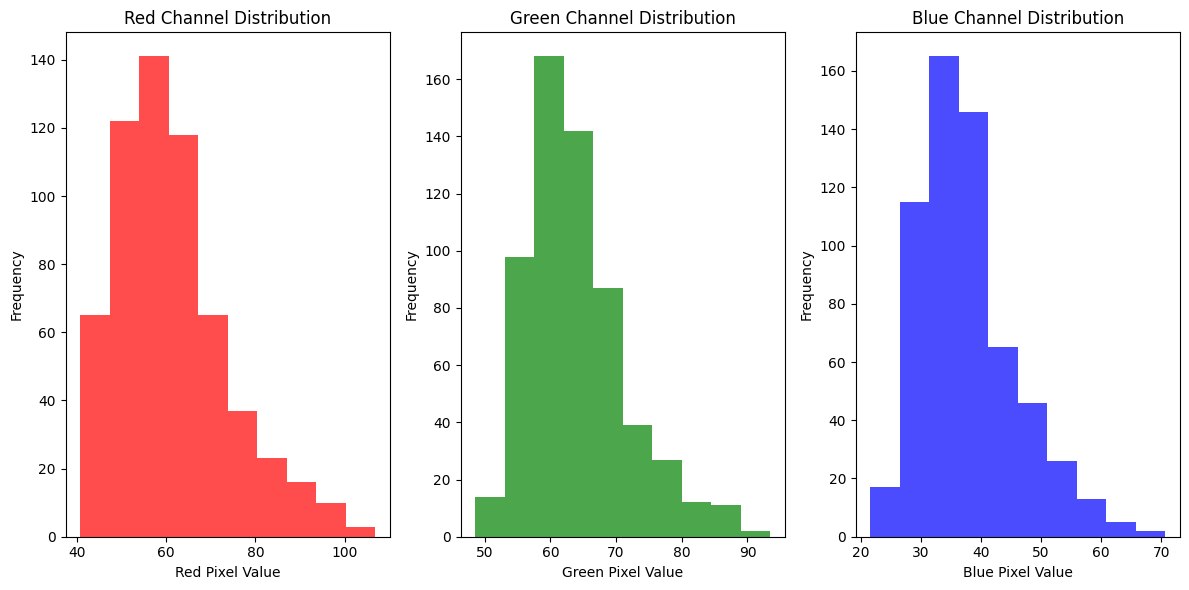

In [53]:


# Create histograms for each color channel
plt.figure(figsize=(12, 6))

# Red channel
plt.subplot(1, 3, 1)
plt.hist(avg_reds, bins=10, color='r', alpha=0.7)
plt.title('Red Channel Distribution')
plt.xlabel('Red Pixel Value')
plt.ylabel('Frequency')

# Green channel
plt.subplot(1, 3, 2)
plt.hist(avg_greens, bins=10, color='g', alpha=0.7)
plt.title('Green Channel Distribution')
plt.xlabel('Green Pixel Value')
plt.ylabel('Frequency')

# Blue channel
plt.subplot(1, 3, 3)
plt.hist(avg_blues, bins=10, color='b', alpha=0.7)
plt.title('Blue Channel Distribution')
plt.xlabel('Blue Pixel Value')
plt.ylabel('Frequency')
plt.savefig(f"../figures/{state}_same_class_count_background_histogram.png")
plt.tight_layout()
plt.show()


In [54]:
## save the results into a csv file
import csv
import pandas as pd
# Prepare the data to be saved into CSV
# state = "bihar"  # Example state

data = {
    "State": [state],
    "Average Red": [mean_red],
    "Average Green": [mean_green],
    "Average Blue": [mean_blue],
    "Std Red": [mean_std_red],
    "Std Green": [mean_std_green],
    "Std Blue": [mean_std_blue]
}

# Convert data into a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = "../result_csv/state_background_rgb_values.csv"
# df.to_csv(csv_file_path, index=False, mode='a', header=not pd.io.common.file_exists(csv_file_path))

# print(f"Results saved to {csv_file_path}")


In [55]:
color_data=pd.read_csv(csv_file_path)
if not os.path.exists("../result_csv/state_background_rgb_values.csv"):
    color_data.to_csv("../result_csv/state_background_rgb_values.csv",index=False)
else:
    df.to_csv("../result_csv/state_background_rgb_values.csv",mode='a',header=False,index=False)